In [1]:
from pytorch_lightning import Trainer
from catinous.CatsinomModelGramCache import CatsinomModelGramCache
from catinous.CatsinomDataset import CatsinomDataset
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
import sklearn 
import pytorch_lightning.logging as pllogging
from sklearn.metrics import confusion_matrix, auc, roc_curve
import torch

%load_ext autoreload
%autoreload 2

In [2]:
hparams = dict()
hparams['root_dir'] = '/project/catinous/cat_data/'
hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
hparams['batch_size'] = 8
hparams['training_batch_size'] = 8
hparams['transition_phase_after'] = 0.7
hparams['cachemaximum'] = 64
hparams['use_cache'] = False
hparams['shuffled_cache'] = True
model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

model.load_state_dict(torch.load('/project/catinous/trained_models/lrbase_iterations.pt'))

<All keys matched successfully>

In [3]:
logger = pllogging.TestTubeLogger('catinous_log_iterations', name='gramcontinuous_wo_cache')
trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=50)
trainer.fit(model)
torch.save(model.state_dict(), '/project/catinous/trained_models/gramcontinuous_wo_cache.pt')

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

Epoch 1:   0%|          | 0/3026 [00:00<?, ?batch/s]

Epoch 1:   8%|▊         | 251/3026 [00:42<05:37,  8.23batch/s, batch_idx=49, gpu=0, loss=0.480, v_num=1]
                                                                

/home/mperkonigg/.local/lib/python3.6/site-packages/pytorch_lightning/callbacks/pt_callbacks.py:314: RuntimeWarning: Can save best model only with val_loss available, skipping.
  ' skipping.', RuntimeWarning)


Epoch 1: 100%|██████████| 3026/3026 [08:13<00:00,  6.13batch/s, batch_idx=613, gpu=0, loss=0.271, v_num=1]


In [4]:
from py_jotools import mut
import numpy as np

[autoreload of catinous.CatsinomModelGramCache failed: Traceback (most recent call last):
  File "/home/mperkonigg/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/mperkonigg/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 450, in superreload
    update_generic(old_obj, new_obj)
  File "/home/mperkonigg/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 387, in update_generic
    update(a, b)
  File "/home/mperkonigg/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 357, in update_class
    update_instances(old, new)
  File "/home/mperkonigg/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 312, in update_instances
    update_instances(old, new, obj.__dict__, visited)
  File "/home/mperkonigg/.local/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 312, in update_instance

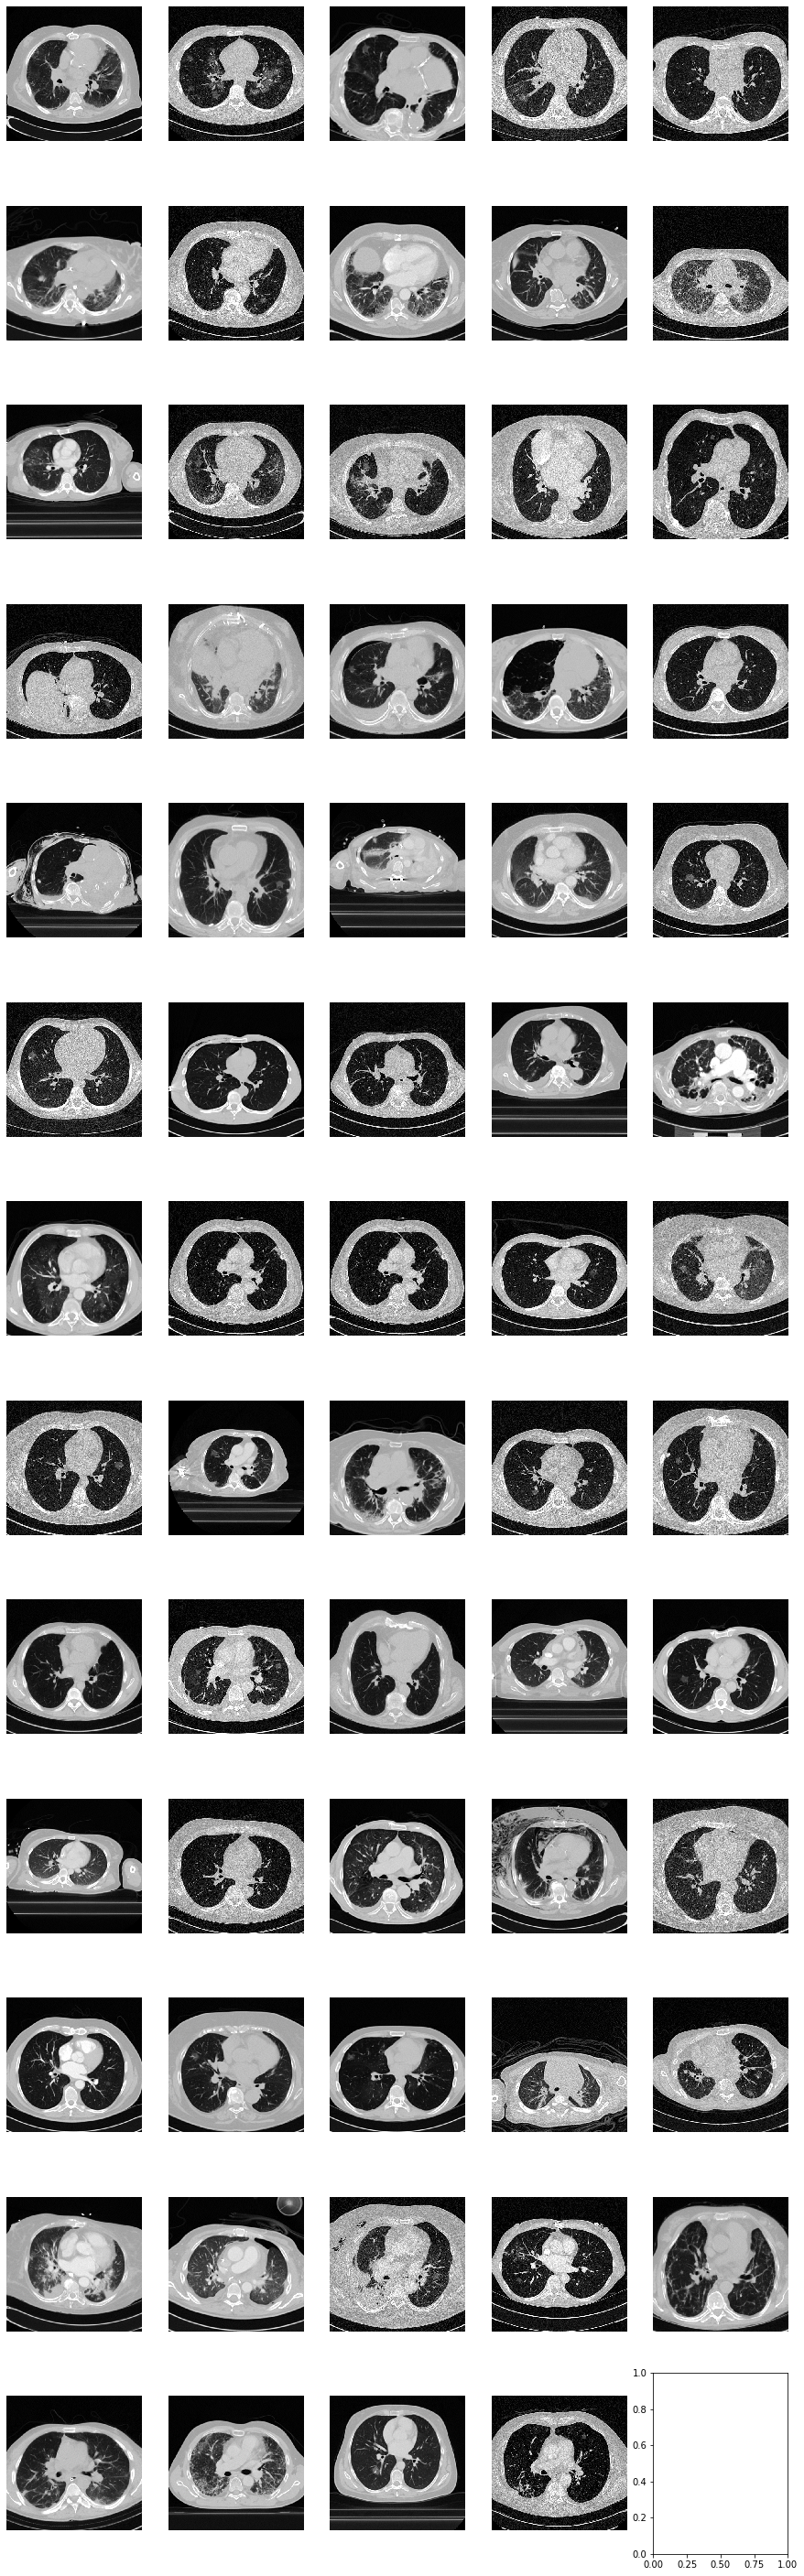

In [5]:
imgs = [x.img.cpu().numpy()[0,0,:,:] for x in model.trainingscache.cachelist]
mut.mimshow(np.asarray(imgs), nslic=64)

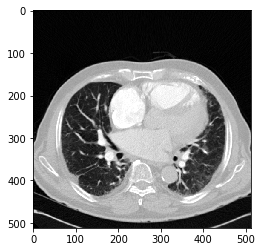

In [20]:
plt.imshow(imgs[33])

In [12]:
for ci in model.trainingscache.cachelist[30:35]:
    print(ci.label, ci.res, ci.traincounter, ci.filepath)

tensor([0], device='cuda:0') hr 0 hr/1L5OACCK_20150101_dicom_257037.dcm
tensor([1], device='cuda:0') hr 53 hr_cat/E595D46E_20120319_dicom_95962.dcm
tensor([1], device='cuda:0') hr 40 hr_cat/1JYWJ3BY_20140211_dicom_119732.dcm
tensor([1], device='cuda:0') lr 73 lr_cat/33E48EF9_20120611_dicom_86420.dcm
tensor([1], device='cuda:0') hr 4 hr_cat/0170DIAL_20140729_dicom_192042.dcm


In [3]:
test_lr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_lr_dataset.csv', split='test'), batch_size=8, num_workers=4)
test_hr = DataLoader(CatsinomDataset('/project/catinous/cat_data/', 'catsinom_hr_dataset.csv', split='test'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [4]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(dsname, datasets, device, base_only=False):
    hparams = dict()
    hparams['root_dir'] = '/project/catinous/cat_data/'
    hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
    hparams['batch_size'] = 2
    hparams['training_batch_size'] = 8
    hparams['transition_phase_after'] = 0.7
    hparams['cachemaximum'] = 8
    
    if base_only:
        dsname = dsname + 'base'
    
    model = CatsinomModelGramCache(argparse.Namespace(**hparams))
    model.load_state_dict(torch.load('/project/catinous/trained_models/' + dsname + '.pt'))
    model.to(device)
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(dsname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

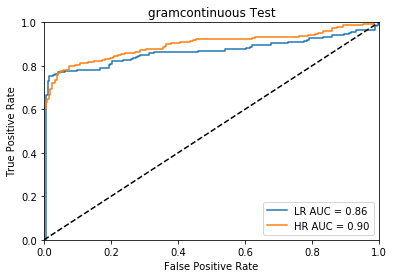

In [34]:
plot_test_roc('gramcontinuous', {'LR': test_lr, 'HR': test_hr}, device)

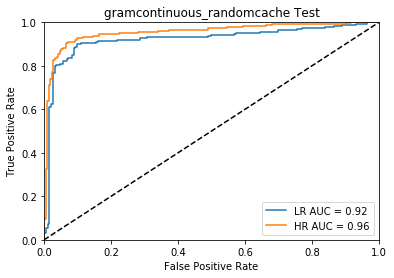

In [6]:
plot_test_roc('gramcontinuous_randomcache', {'LR': test_lr, 'HR': test_hr}, device)

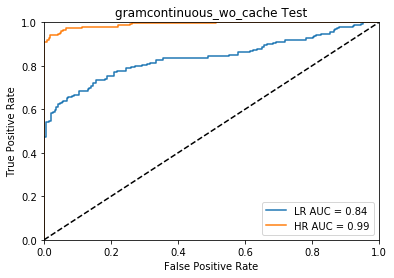

In [7]:
plot_test_roc('gramcontinuous_wo_cache', {'LR': test_lr, 'HR': test_hr}, device)

In [7]:
out = model(torch.tensor(test_lr_ds[40][0][None, :, :, :]).float())
lr_grammat1 = model.grammatrices.copy()

out = model(torch.tensor(test_lr_ds[-40][0][None, :, :, :]).float())
lr_grammat2 = model.grammatrices.copy()

out = model(torch.tensor(test_hr_ds[40][0][None, :, :, :]).float())
hr_grammat1 = model.grammatrices.copy()

out = model(torch.tensor(test_hr_ds[-40][0][None, :, :, :]).float())
hr_grammat2 = model.grammatrices.copy()

In [2]:
hparams = dict()
hparams['root_dir'] = '/project/catinous/cat_data/'
hparams['datasetfile'] = 'catsinom_combined_dataset.csv'
hparams['batch_size'] = 8
hparams['training_batch_size'] = 8
hparams['transition_phase_after'] = 0.7
hparams['cachemaximum'] = 8
hparams['use_cache'] = False
model = CatsinomModelGramCache(argparse.Namespace(**hparams), device = torch.device('cuda'))

model.load_state_dict(torch.load('/project/catinous/trained_models/lrbase_iterations.pt'))

<All keys matched successfully>

In [3]:
logger = pllogging.TestTubeLogger('catinous_log_iterations', name='continous_wo_cache')
trainer = Trainer(gpus=1, max_epochs=1, early_stop_callback=False, logger=logger, val_check_interval=500)
trainer.fit(model)
torch.save(model.state_dict(), '/project/catinous/trained_models/continous_wo_cache.pt')

INFO:root:gpu available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

Epoch 1:   0%|          | 0/815 [00:00<?, ?batch/s]

Epoch 1: 100%|██████████| 815/815 [03:13<00:00,  4.20batch/s, batch_idx=613, gpu=0, loss=0.246, v_num=3]


In [2]:
from torch import tensor

In [14]:
test_comb_ds = CatsinomDataset('/project/catinous/cat_data/', 'catsinom_combined_dataset.csv', split='test')

In [10]:
out = model(torch.tensor(batch[0]).float())
lr_grammat2 = model.grammatrices.copy()

/home/mperkonigg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [11]:
len(lr_grammat2)

8

In [8]:
for i in range(len(lr_grammat2)):
    print(lr_grammat2[i][0].size(), len(lr_grammat2[i]))

torch.Size([256, 256]) 4
torch.Size([512, 512]) 4
torch.Size([1024, 1024]) 4
torch.Size([2048, 2048]) 4


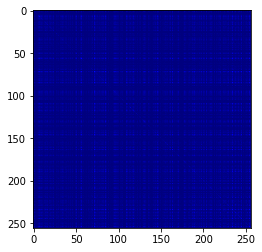

In [11]:
plt.imshow(lr_grammat1[0], cmap='jet', vmax=0.0090)

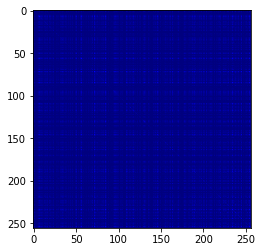

In [12]:
plt.imshow(lr_grammat2[0], cmap='jet', vmax=0.0090)

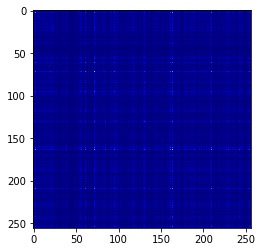

In [13]:
plt.imshow(hr_grammat1[0], cmap='jet', vmax=0.0090)

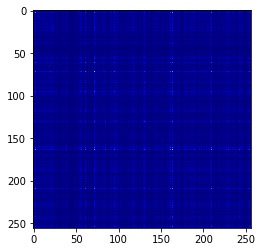

In [14]:
plt.imshow(hr_grammat1[0], cmap='jet', vmax=0.0090)